In [3]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#### **ROI extraction**

In [251]:
# Load the Excel data into a DataFrame
df = pd.read_excel('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/ObjectDetection.xlsx') 

# Filter the DataFrame to only include rows where the structure is "NT"
nt_df = df[df['structure'] == 'NT']

# Directory containing the ultrasound images
image_dir = '/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set1-Training&Validation Sets CNN/Standard'  # Update this path
nt_dir = '/Users/shravyadsouza/Downloads/untitled folder/nt_dir30'  # Folder to save only NT cropped images
os.makedirs(nt_dir, exist_ok=True)

In [37]:
# Load the Excel data into a DataFrame
df = pd.read_excel('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/ObjectDetection.xlsx') 

# Filter the DataFrame to only include rows where the structure is "NT"
nt_df = df[df['structure'] == 'NT']

# Directory containing the ultrasound images
image_dir = '/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard'  # Update this path
nt_dir = '/Users/shravyadsouza/Downloads/untitled folder/nt_dir30'  # Folder to save only NT cropped images
os.makedirs(nt_dir, exist_ok=True)

In [39]:
# List to store the results (image name, nt_thickness)
results = []

In [41]:
# Iterate through each row in the filtered DataFrame (only NT structures)
for index, row in nt_df.iterrows():
    image_name = row['fname']
    structure = row['structure']
    h_min, w_min, h_max, w_max = row['h_min'], row['w_min'], row['h_max'], row['w_max']
    
    # Load the image
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)
    
    if image is not None:
        # Crop the image using the bounding box coordinates for the NT region
        roi = image[h_min:h_max, w_min:w_max]
        
        # Save the cropped ROI with the structure name (NT) included in the filename
        output_filename = f"{os.path.splitext(image_name)[0]}_NT.png"
        output_path = os.path.join(nt_dir, output_filename)
        cv2.imwrite(output_path, roi)
        print(f"Cropped and saved {output_filename}")
        
        # Calculate the NT thickness (height of the bounding box)
        nt_thickness = h_max - h_min
        
        # Store the result (image name and NT thickness)
        results.append({'fname': image_name, 'nt_thickness': nt_thickness})
    else:
        print(f"Image {image_name} not found.")

[ WARN:0@4.390] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/168.png'): can't open/read file: check file path/integrity
[ WARN:0@4.391] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/169.png'): can't open/read file: check file path/integrity
[ WARN:0@4.391] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/170.png'): can't open/read file: check file path/integrity
[ WARN:0@4.392] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Fra

Image 168.png not found.
Image 169.png not found.
Image 170.png not found.
Image 171.png not found.
Image 172.png not found.
Image 173.png not found.
Image 9.png not found.
Cropped and saved 832_NT.png
Cropped and saved 833_NT.png
Cropped and saved 834_NT.png
Image 117.png not found.
Image 174.png not found.
Image 175.png not found.
Image 176.png not found.
Image 177.png not found.
Image 178.png not found.
Image 179.png not found.
Image 10.png not found.
Cropped and saved 835_NT.png
Image 1535.png not found.
Cropped and saved 836_NT.png
Image 118.png not found.
Image 180.png not found.
Image 181.png not found.
Image 182.png not found.
Image 183.png not found.
Image 184.png not found.
Image 185.png not found.
Image 11.png not found.
Cropped and saved 837_NT.png
Cropped and saved 838_NT.png
Image 119.png not found.
Image 186.png not found.
Image 187.png not found.
Image 188.png not found.
Image 189.png not found.
Image 190.png not found.
Image 191.png not found.
Image 12.png not found.
C

[ WARN:0@4.579] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/219.png'): can't open/read file: check file path/integrity
[ WARN:0@4.579] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/220.png'): can't open/read file: check file path/integrity
[ WARN:0@4.579] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/17.png'): can't open/read file: check file path/integrity
[ WARN:0@4.600] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Fram

Cropped and saved 869_NT.png
Cropped and saved 815_NT.png
Image 271.png not found.
Image 272.png not found.
Image 273.png not found.
Image 274.png not found.
Image 275.png not found.
Image 276.png not found.
Image 26.png not found.
Cropped and saved 870_NT.png
Cropped and saved 871_NT.png
Image 1541.png not found.
Cropped and saved 816_NT.png
Image 277.png not found.
Image 278.png not found.
Image 279.png not found.
Image 280.png not found.
Image 27.png not found.
Cropped and saved 872_NT.png
Image 1542.png not found.
Cropped and saved 817_NT.png
Image 113.png not found.
Image 281.png not found.
Image 282.png not found.
Image 283.png not found.
Image 284.png not found.
Image 285.png not found.
Image 286.png not found.
Image 28.png not found.
Cropped and saved 873_NT.png
Cropped and saved 874_NT.png
Image 1543.png not found.
Image 128.png not found.
Image 287.png not found.
Image 288.png not found.
Image 289.png not found.
Image 290.png not found.
Image 291.png not found.
Image 292.png 

[ WARN:0@4.762] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/127.png'): can't open/read file: check file path/integrity
[ WARN:0@4.762] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/260.png'): can't open/read file: check file path/integrity
[ WARN:0@4.762] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/261.png'): can't open/read file: check file path/integrity
[ WARN:0@4.762] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Fra

Cropped and saved 892_NT.png
Cropped and saved 893_NT.png
Image 134.png not found.
Image 343.png not found.
Image 344.png not found.
Image 345.png not found.
Image 346.png not found.
Image 347.png not found.
Image 348.png not found.
Image 39.png not found.
Cropped and saved 894_NT.png
Image 1549.png not found.
Image 135.png not found.
Image 349.png not found.
Image 350.png not found.
Image 351.png not found.
Image 352.png not found.
Image 353.png not found.
Image 354.png not found.
Image 40.png not found.
Cropped and saved 895_NT.png
Cropped and saved 896_NT.png
Cropped and saved 897_NT.png
Image 136.png not found.
Image 355.png not found.
Image 356.png not found.
Image 357.png not found.
Image 358.png not found.
Image 359.png not found.
Image 41.png not found.
Image 1550.png not found.
Cropped and saved 898_NT.png
Cropped and saved 899_NT.png
Image 137.png not found.
Image 360.png not found.
Image 361.png not found.
Image 362.png not found.
Image 363.png not found.
Image 364.png not f

[ WARN:0@5.225] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/134.png'): can't open/read file: check file path/integrity
[ WARN:0@5.225] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/343.png'): can't open/read file: check file path/integrity
[ WARN:0@5.226] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/344.png'): can't open/read file: check file path/integrity
[ WARN:0@5.226] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Fra

Cropped and saved 907_NT.png
Image 380.png not found.
Image 382.png not found.
Image 383.png not found.
Image 384.png not found.
Image 46.png not found.
Cropped and saved 908_NT.png
Image 1553.png not found.
Cropped and saved 909_NT.png
Cropped and saved 821_NT.png
Image 385.png not found.
Image 386.png not found.
Image 387.png not found.
Image 388.png not found.
Image 389.png not found.
Image 390.png not found.
Image 47.png not found.
Cropped and saved 910_NT.png
Image 1554.png not found.
Cropped and saved 911_NT.png
Cropped and saved 822_NT.png
Image 115.png not found.
Image 391.png not found.
Image 392.png not found.
Image 393.png not found.
Image 394.png not found.
Image 395.png not found.
Image 48.png not found.
Cropped and saved 912_NT.png
Cropped and saved 913_NT.png
Image 139.png not found.
Image 396.png not found.
Image 397.png not found.
Image 398.png not found.
Image 399.png not found.
Image 400.png not found.
Image 401.png not found.
Image 49.png not found.
Cropped and save

ets ANN Scoring system/Standard/353.png'): can't open/read file: check file path/integrity
[ WARN:0@5.243] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/354.png'): can't open/read file: check file path/integrity
[ WARN:0@5.243] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/40.png'): can't open/read file: check file path/integrity
[ WARN:0@5.290] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/136.png'): can't open/read file: check file path/integrity
[ WARN:0@5.290] global loadsave.cpp:241 findDecoder imread_('/Users

Cropped and saved 926_NT.png
Image 432.png not found.
Image 433.png not found.
Image 434.png not found.
Image 435.png not found.
Image 436.png not found.
Image 437.png not found.
Image 54.png not found.
Cropped and saved 927_NT.png
Cropped and saved 928_NT.png
Cropped and saved 823_NT.png
Image 438.png not found.
Image 439.png not found.
Image 440.png not found.
Image 441.png not found.
Image 442.png not found.
Image 443.png not found.
Image 55.png not found.
Cropped and saved 929_NT.png
Cropped and saved 824_NT.png
Image 444.png not found.
Image 445.png not found.
Image 446.png not found.
Image 447.png not found.
Image 448.png not found.
Image 449.png not found.
Image 56.png not found.
Image 1557.png not found.
Cropped and saved 931_NT.png
Image 116.png not found.
Image 450.png not found.
Image 451.png not found.
Image 452.png not found.
Image 453.png not found.
Image 454.png not found.
Image 455.png not found.
Image 57.png not found.
Image 1558.png not found.
Cropped and saved 932_NT

[ WARN:0@5.626] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/436.png'): can't open/read file: check file path/integrity
[ WARN:0@5.626] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/437.png'): can't open/read file: check file path/integrity
[ WARN:0@5.626] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/54.png'): can't open/read file: check file path/integrity
[ WARN:0@5.649] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Fram

Cropped and saved 947_NT.png
Image 495.png not found.
Image 496.png not found.
Image 497.png not found.
Image 498.png not found.
Image 499.png not found.
Image 500.png not found.
Image 63.png not found.
Cropped and saved 948_NT.png
Cropped and saved 949_NT.png
Cropped and saved 950_NT.png
Image 1531.png not found.
Image 501.png not found.
Image 502.png not found.
Image 503.png not found.
Image 504.png not found.
Image 505.png not found.
Image 506.png not found.
Image 64.png not found.
Cropped and saved 951_NT.png
Cropped and saved 952_NT.png
Cropped and saved 953_NT.png
Image 1532.png not found.
Image 0.png not found.
Image 507.png not found.
Image 508.png not found.
Image 509.png not found.
Image 510.png not found.
Image 511.png not found.
Image 512.png not found.
Image 65.png not found.
Cropped and saved 954_NT.png
Cropped and saved 955_NT.png
Cropped and saved 956_NT.png
Image 151.png not found.
Image 514.png not found.
Image 515.png not found.
Image 516.png not found.
Image 517.png

mework/Set2-Training&Validation Sets ANN Scoring system/Standard/500.png'): can't open/read file: check file path/integrity
[ WARN:0@5.832] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/63.png'): can't open/read file: check file path/integrity
[ WARN:0@5.860] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/1531.png'): can't open/read file: check file path/integrity
[ WARN:0@5.860] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/501.png'): can't open/read file: check file path/integrity
[ WARN:0@5.860] global loadsave.c

Cropped and saved 967_NT.png
Image 156.png not found.
Image 542.png not found.
Image 543.png not found.
Image 544.png not found.
Image 545.png not found.
Image 546.png not found.
Image 547.png not found.
Image 70.png not found.
Cropped and saved 968_NT.png
Image 1568.png not found.
Cropped and saved 969_NT.png
Image 6.png not found.
Image 548.png not found.
Image 549.png not found.
Image 550.png not found.
Image 551.png not found.
Image 552.png not found.
Cropped and saved 970_NT.png
Image 1569.png not found.
Cropped and saved 826_NT.png
Image 554.png not found.
Image 555.png not found.
Image 556.png not found.
Image 557.png not found.
Image 558.png not found.
Image 559.png not found.
Image 72.png not found.
Cropped and saved 971_NT.png
Cropped and saved 972_NT.png
Cropped and saved 827_NT.png
Image 560.png not found.
Image 561.png not found.
Image 562.png not found.
Image 563.png not found.
Image 73.png not found.
Cropped and saved 973_NT.png
Cropped and saved 974_NT.png
Image 1570.pn

[ WARN:0@6.070] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/6.png'): can't open/read file: check file path/integrity
[ WARN:0@6.070] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/548.png'): can't open/read file: check file path/integrity
[ WARN:0@6.071] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/549.png'): can't open/read file: check file path/integrity
[ WARN:0@6.071] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Frame

Cropped and saved 981_NT.png
Image 160.png not found.
Image 587.png not found.
Image 588.png not found.
Image 589.png not found.
Image 590.png not found.
Image 591.png not found.
Image 592.png not found.
Image 78.png not found.
Cropped and saved 982_NT.png
Image 1573.png not found.
Cropped and saved 983_NT.png
Image 161.png not found.
Image 593.png not found.
Image 594.png not found.
Image 595.png not found.
Image 596.png not found.
Image 597.png not found.
Image 79.png not found.
Cropped and saved 984_NT.png
Cropped and saved 985_NT.png
Image 1574.png not found.
Image 162.png not found.
Image 598.png not found.
Image 599.png not found.
Image 600.png not found.
Image 601.png not found.
Image 602.png not found.
Image 603.png not found.
Image 80.png not found.
Cropped and saved 986_NT.png
Cropped and saved 987_NT.png
Cropped and saved 988_NT.png
Image 604.png not found.
Image 1533.png not found.
Cropped and saved 828_NT.png
Cropped and saved 829_NT.png
Cropped and saved 813_NT.png
Image 

[ WARN:0@6.275] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/161.png'): can't open/read file: check file path/integrity
[ WARN:0@6.276] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/593.png'): can't open/read file: check file path/integrity
[ WARN:0@6.277] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/594.png'): can't open/read file: check file path/integrity
[ WARN:0@6.277] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Fra

Cropped and saved 1013_NT.png
Image 1584.png not found.
Image 612.png not found.
Image 680.png not found.
Image 681.png not found.
Image 682.png not found.
Image 683.png not found.
Image 684.png not found.
Image 94.png not found.
Cropped and saved 1014_NT.png
Cropped and saved 1015_NT.png
Image 613.png not found.
Image 685.png not found.
Image 686.png not found.
Image 687.png not found.
Image 688.png not found.
Image 689.png not found.
Image 95.png not found.
Image 1585.png not found.
Cropped and saved 1017_NT.png
Image 614.png not found.
Image 690.png not found.
Image 691.png not found.
Image 692.png not found.
Image 693.png not found.
Image 694.png not found.
Image 695.png not found.
Image 96.png not found.
Cropped and saved 1018_NT.png
Image 1586.png not found.
Cropped and saved 1019_NT.png
Image 615.png not found.
Image 696.png not found.
Image 697.png not found.
Image 698.png not found.
Image 699.png not found.
Image 700.png not found.
Image 701.png not found.
Image 97.png not fou

[ WARN:0@6.482] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/613.png'): can't open/read file: check file path/integrity
[ WARN:0@6.483] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/685.png'): can't open/read file: check file path/integrity
[ WARN:0@6.483] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/686.png'): can't open/read file: check file path/integrity
[ WARN:0@6.483] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Fra

Cropped and saved 1031_NT.png
Cropped and saved 1032_NT.png
Image 616.png not found.
Image 725.png not found.
Image 726.png not found.
Image 727.png not found.
Image 728.png not found.
Image 729.png not found.
Image 730.png not found.
Image 101.png not found.
Image 1588.png not found.
Cropped and saved 1033_NT.png
Cropped and saved 1034_NT.png
Image 617.png not found.
Image 731.png not found.
Image 732.png not found.
Image 733.png not found.
Image 734.png not found.
Image 735.png not found.
Image 736.png not found.
Image 102.png not found.
Cropped and saved 1035_NT.png
Image 1589.png not found.
Cropped and saved 1036_NT.png
Image 618.png not found.
Image 737.png not found.
Image 738.png not found.
Image 739.png not found.
Image 740.png not found.
Image 741.png not found.
Image 742.png not found.
Image 103.png not found.
Cropped and saved 1037_NT.png
Image 1590.png not found.
Image 619.png not found.
Image 743.png not found.
Image 744.png not found.
Image 745.png not found.
Image 746.pn

[ WARN:0@6.691] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/617.png'): can't open/read file: check file path/integrity
[ WARN:0@6.691] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/731.png'): can't open/read file: check file path/integrity
[ WARN:0@6.692] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/732.png'): can't open/read file: check file path/integrity
[ WARN:0@6.692] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Fra

Cropped and saved 1045_NT.png
Cropped and saved 1046_NT.png
Image 1593.png not found.
Cropped and saved 989_NT.png
Image 767.png not found.
Image 768.png not found.
Image 769.png not found.
Image 770.png not found.
Image 771.png not found.
Image 772.png not found.
Image 107.png not found.
Cropped and saved 1047_NT.png
Cropped and saved 1048_NT.png
Image 1594.png not found.
Cropped and saved 990_NT.png
Image 773.png not found.
Image 774.png not found.
Image 775.png not found.
Image 776.png not found.
Image 777.png not found.
Image 778.png not found.
Cropped and saved 1049_NT.png
Cropped and saved 1050_NT.png
Image 1595.png not found.
Cropped and saved 991_NT.png
Image 606.png not found.
Image 779.png not found.
Image 780.png not found.
Image 781.png not found.
Image 782.png not found.
Image 783.png not found.
Image 108.png not found.
Cropped and saved 1051_NT.png
Cropped and saved 1052_NT.png
Image 1596.png not found.
Image 622.png not found.
Image 784.png not found.
Image 785.png not f

[ WARN:0@6.959] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/1593.png'): can't open/read file: check file path/integrity
[ WARN:0@6.971] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/767.png'): can't open/read file: check file path/integrity
[ WARN:0@6.972] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/768.png'): can't open/read file: check file path/integrity
[ WARN:0@6.972] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Fr

Cropped and saved 1056_NT.png
Image 623.png not found.
Image 795.png not found.
Image 796.png not found.
Image 797.png not found.
Image 798.png not found.
Image 799.png not found.
Image 800.png not found.
Image 111.png not found.
Cropped and saved 1057_NT.png
Image 1598.png not found.
Cropped and saved 1058_NT.png
Image 624.png not found.
Image 801.png not found.
Image 802.png not found.
Image 803.png not found.
Image 804.png not found.
Image 805.png not found.
Image 806.png not found.
Image 112.png not found.
Cropped and saved 1059_NT.png
Cropped and saved 1060_NT.png
Image 1599.png not found.
Image 625.png not found.
Image 807.png not found.
Image 808.png not found.
Image 809.png not found.
Image 810.png not found.
Image 811.png not found.
Image 626.png not found.
Image 84.png not found.
Cropped and saved 992_NT.png
Cropped and saved 993_NT.png
Image 607.png not found.
Image 627.png not found.
Image 628.png not found.
Image 629.png not found.
Image 630.png not found.
Image 631.png no

[ WARN:0@7.172] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/607.png'): can't open/read file: check file path/integrity
[ WARN:0@7.172] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/627.png'): can't open/read file: check file path/integrity
[ WARN:0@7.172] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Set2-Training&Validation Sets ANN Scoring system/Standard/628.png'): can't open/read file: check file path/integrity
[ WARN:0@7.173] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Fra

In [43]:
# Create a DataFrame to save the NT thickness results
nt_thickness_df = pd.DataFrame(results)

In [45]:
# Save the NT thickness results to a CSV file
output_csv = '/Users/shravyadsouza/Downloads/untitled folder/nt_thickness_results30.csv'  # Update this path
nt_thickness_df.to_csv(output_csv, index=False)

In [47]:
# Save the NT thickness results to a CSV file
output_csv = '/Users/shravyadsouza/Downloads/untitled folder/nt_thickness_results30pt1.csv'  # Update this path
nt_thickness_df.to_csv(output_csv, index=False)

In [49]:
print(f"NT thickness values calculated and saved to {output_csv}")

NT thickness values calculated and saved to /Users/shravyadsouza/Downloads/untitled folder/nt_thickness_results30pt1.csv


In [51]:
# Directory where cropped images are saved
cropped_image_dir = '/Users/shravyadsouza/Downloads/untitled folder/nt_dir30'

# Get a list of files in the directory
cropped_images = [f for f in os.listdir(cropped_image_dir) if os.path.isfile(os.path.join(cropped_image_dir, f))]

# Count the number of cropped images
cropped_image_count = len(cropped_images)

print(f"Number of cropped images: {cropped_image_count}")

Number of cropped images: 1038


In [186]:
dataframe = pd.read_csv(output_csv)
dataframe.head()

,fname,nt_thickness
0,832.png,38
1,833.png,47
2,834.png,29
3,835.png,33
4,836.png,23


In [188]:
len(dataframe)

244

In [190]:
# Define NT thickness threshold for classification
NT_THRESHOLD = 35

# Classify each image based on NT thickness
dataframe['classification'] = dataframe['nt_thickness'].apply(lambda x: 'High Risk' if x > NT_THRESHOLD else 'Normal')
dataframe['fname'] = dataframe['fname'].apply(lambda x: f"{os.path.splitext(x)[0]}_NT.png")

# Display the labeled data
print(dataframe.head())

        fname  nt_thickness classification
0  832_NT.png            38      High Risk
1  833_NT.png            47      High Risk
2  834_NT.png            29         Normal
3  835_NT.png            33         Normal
4  836_NT.png            23         Normal


In [192]:
# Save the updated DataFrame back to a CSV file
output_csv = '/Users/shravyadsouza/Downloads/untitled folder/nt_thickness_results_with_labels30pt1.csv'  # Update with your desired path
dataframe.to_csv(output_csv, index=False)

print(f"NT thickness values with classification labels saved to {output_csv}")

NT thickness values with classification labels saved to /Users/shravyadsouza/Downloads/untitled folder/nt_thickness_results_with_labels30pt1.csv


In [194]:
import pandas as pd

# Load the two CSV files
file1 = '/Users/shravyadsouza/Downloads/untitled folder/nt_thickness_results_with_labels30pt1.csv'
file2 = '/Users/shravyadsouza/Downloads/untitled folder/nt_thickness_results_with_labels30.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Concatenate the DataFrames row-wise (axis=0)
combined_df = pd.concat([df1, df2], axis=0, ignore_index=True)

# Optional: Drop duplicates if any (based on 'fname' column)
combined_df = combined_df.drop_duplicates(subset='fname', keep='first')

# Save the combined DataFrame to a new CSV file
combined_csv_path = '/Users/shravyadsouza/Downloads/untitled folder/nt_thickness-combined_file.csv'
combined_df.to_csv(combined_csv_path, index=False)

print(f"Combined CSV saved successfully at {combined_csv_path}")

Combined CSV saved successfully at /Users/shravyadsouza/Downloads/untitled folder/nt_thickness-combined_file.csv


In [196]:
dataframe = pd.read_csv('/Users/shravyadsouza/Downloads/untitled folder/nt_thickness-combined_file.csv')

In [198]:
len(dataframe)

1038

In [200]:
# Check the class distribution
class_distribution = dataframe['classification'].value_counts()
print("Class Distribution:\n", class_distribution)

# Optionally, you can balance the classes by oversampling or undersampling
# For this example, we'll assume the data is balanced.

Class Distribution:
 classification
Normal       579
High Risk    459
Name: count, dtype: int64


In [73]:
from tqdm import tqdm

In [75]:
# Directory where cropped images are saved
cropped_image_dir = '/Users/shravyadsouza/Downloads/untitled folder/nt_dir30'  # Update this path
resized_image_dir = '/Users/shravyadsouza/Downloads/untitled folder/resized_images30'  # Directory to save resized images
os.makedirs(resized_image_dir, exist_ok=True)

In [77]:
# Target size for resizing
target_size = (400, 100)  # (width, height) as per paper

In [79]:
# Iterate through each cropped image, resize it, and save it
for filename in tqdm(os.listdir(cropped_image_dir)):
    if filename.endswith(".png"):
        # Load the cropped image
        image_path = os.path.join(cropped_image_dir, filename)
        image = cv2.imread(image_path)
        
        # Check if the image is loaded correctly
        if image is not None:
            # Resize the image to 100x400 pixels
            resized_image = cv2.resize(image, target_size)
            
            # Save the resized image
            output_path = os.path.join(resized_image_dir, filename)
            cv2.imwrite(output_path, resized_image)
        else:
            print(f"Error loading image {filename}")
            
print("Resizing complete and images saved.")

100%|██████████████████████████████████████| 1038/1038 [00:04<00:00, 254.36it/s]

Resizing complete and images saved.


In [74]:
# Assuming you have a DataFrame named `dataframe` with image filenames and classifications
from sklearn.model_selection import train_test_split

# Split the main DataFrame into train and test sets
train_df, test_df = train_test_split(dataframe, test_size=0.2, stratify=dataframe['classification'], random_state=42)

# Display a few rows to verify
print("Training DataFrame:")
print(train_df.head())

print("Testing DataFrame:")
print(test_df.head())

Training DataFrame:
          fname  nt_thickness classification
325  422_NT.png            19         Normal
172  131_NT.png            49      High Risk
185  313_NT.png            29         Normal
437  514_NT.png            31         Normal
210  332_NT.png            23         Normal
Testing DataFrame:
          fname  nt_thickness classification
562   91_NT.png            28         Normal
573  675_NT.png            47      High Risk
324  421_NT.png            37      High Risk
76   230_NT.png            20         Normal
216   37_NT.png            31         Normal


In [76]:
len(train_df)

635

In [78]:
len(test_df)

159

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training and testing
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=resized_image_dir,  # Directory where resized images are stored
    x_col='fname',
    y_col='classification',
    target_size=(100, 400),  # Resized dimensions as per paper
    batch_size=32,
    class_mode='binary'  # Binary classification: Normal/High Risk
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=resized_image_dir,
    x_col='fname',
    y_col='classification',
    target_size=(100, 400),  # Resized dimensions
    batch_size=32,
    class_mode='binary'
)

Found 635 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.


In [82]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Add, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation

# Define the residual block function
def residual_block(input_tensor, filters, kernel_size=3):
    """Residual block function"""
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)

    # Add the input (skip connection) to the output
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

# Define the model using functional API
input_shape = (100, 400, 3)
inputs = Input(shape=input_shape)

# Layer 1: Initial convolutional layer
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)  # Layer 2
x = MaxPooling2D((2, 2))(x)  # Layer 3

# Layer 4-8: Residual Block
x = residual_block(x, 64)  
x = MaxPooling2D((2, 2))(x)  # Layer 9

# Layer 10: Flatten
x = Flatten()(x)

# Layer 11: Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = models.Model(inputs, outputs)

# Compile the model with Adam optimizer and binary cross entropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary to verify layer count
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 400,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 200,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 200,   │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 200,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 50, 200,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 50, 200,   │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 200,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 200,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 50, 200,   │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 100,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 160000)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │    160,001 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 235,905 (921.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [86]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model using the train and test generators
history = model.fit(
    train_generator,  # Training data generator
    validation_data=test_generator,  # Validation data generator
    epochs=300,  # Number of epochs as mentioned in the paper
    callbacks=[early_stopping, reduce_lr],  # Add callbacks for better training control
    verbose=1  # Verbose mode to see training progress
)

Epoch 1/300


/Users/shravyadsouza/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.5120 - loss: 1.5019 - val_accuracy: 0.6604 - val_loss: 0.6689 - learning_rate: 1.0000e-04
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.7256 - loss: 0.6273 - val_accuracy: 0.5912 - val_loss: 0.6808 - learning_rate: 1.0000e-04
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7188 - loss: 0.5877 - val_accuracy: 0.5597 - val_loss: 0.6751 - learning_rate: 1.0000e-04
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.7883 - loss: 0.4697 - val_accuracy: 0.4340 - val_loss: 0.7012 - learning_rate: 1.0000e-04
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.7987 - loss: 0.4862 - val_accuracy: 0.6981 - val_loss: 0.6667 - learning_rate: 1.0000e-04
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.7656 - loss: 0.5295 - val_accuracy: 0.5849 - val_loss: 0.6402 - learning_rate: 1.0000e-04
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.7697 - loss: 

In [90]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(test_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 739ms/step - accuracy: 0.8608 - loss: 0.2881
Validation Loss: 0.2992698848247528
Validation Accuracy: 0.8742138147354126


In [94]:
model.save('/Users/shravyadsouza/Downloads/untitled folder/final_model_epoch_53.h5')
print("Model saved successfully!")

Model saved successfully!


In [96]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions for the entire validation set
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred)  # Round to 0 or 1

# Get true labels
true_labels = test_generator.classes

# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(true_labels, y_pred))
print("Confusion Matrix:\n", confusion_matrix(true_labels, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 751ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.41      0.42        69
           1       0.57      0.61      0.59        90

    accuracy                           0.52       159
   macro avg       0.51      0.51      0.51       159
weighted avg       0.52      0.52      0.52       159

Confusion Matrix:
 [[28 41]
 [35 55]]


## **Re-training the model with 1038 dataset**

In [5]:
import pandas as pd

In [7]:
dataframe = pd.read_csv('/Users/shravyadsouza/Downloads/untitled folder/nt_thickness-combined_file.csv')
resized_image_dir = '/Users/shravyadsouza/Downloads/untitled folder/resized_images30'  # Directory to save resized images

In [9]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = '/Users/shravyadsouza/Downloads/untitled folder/nt_thickness-combined_file.csv'

# Load the CSV file containing the incorrect filenames
dataframe = pd.read_csv(csv_file_path)

# Function to fix filenames in the CSV (remove duplicate "_NT" suffix)
def fix_filename_in_csv(filename):
    if filename.endswith('_NT_NT.png'):
        return filename.replace('_NT_NT.png', '_NT.png')
    else:
        return filename

# Apply the filename correction to the 'fname' column in the DataFrame
dataframe['fname'] = dataframe['fname'].apply(fix_filename_in_csv)

# Display the updated filenames to verify the changes
print("Updated filenames in CSV:")
print(dataframe['fname'].head())

# Save the updated DataFrame back to the same CSV file
dataframe.to_csv(csv_file_path, index=False)
print(f"CSV file updated successfully with corrected filenames: {csv_file_path}")

Updated filenames in CSV:
0    832_NT.png
1    833_NT.png
2    834_NT.png
3    835_NT.png
4    836_NT.png
Name: fname, dtype: object
CSV file updated successfully with corrected filenames: /Users/shravyadsouza/Downloads/untitled folder/nt_thickness-combined_file.csv


In [11]:
# Display the first few filenames from the DataFrame
print("First few filenames in 'fname' column:")
print(dataframe['fname'].head())

First few filenames in 'fname' column:
0    832_NT.png
1    833_NT.png
2    834_NT.png
3    835_NT.png
4    836_NT.png
Name: fname, dtype: object


In [13]:
from sklearn.model_selection import train_test_split

# Step 2: Create training and validation sets (80/20 split)
train_df, test_df = train_test_split(dataframe, test_size=0.2, stratify=dataframe['classification'], random_state=42)

# Step 3: Verify the size of the splits
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(test_df)}")

Training set size: 830
Validation set size: 208


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Scale pixel values to [0, 1]
    rotation_range=30,  # Data augmentation: random rotations
    width_shift_range=0.2,  # Data augmentation: horizontal shift
    height_shift_range=0.2,  # Data augmentation: vertical shift
    shear_range=0.2,  # Data augmentation: shearing
    zoom_range=0.2,  # Data augmentation: zooming
    horizontal_flip=True,  # Data augmentation: horizontal flipping
    fill_mode='nearest'  # Fill mode for pixels outside boundaries
)

# Define a separate ImageDataGenerator for testing/validation (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create training generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=resized_image_dir,  # Directory where resized images are stored
    x_col='fname',  # Column in DataFrame that contains filenames
    y_col='classification',  # Column in DataFrame that contains labels
    target_size=(100, 400),  # Set the target size to match your image dimensions
    batch_size=32,
    class_mode='binary',  # Binary classification: Normal/High Risk
    shuffle=True  # Shuffle the data during training
)

# Create validation generator
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=resized_image_dir,  # Directory where resized images are stored
    x_col='fname',  # Column in DataFrame that contains filenames
    y_col='classification',  # Column in DataFrame that contains labels
    target_size=(100, 400),  # Set the target size to match your image dimensions
    batch_size=32,
    class_mode='binary',  # Binary classification: Normal/High Risk
    shuffle=False  # Do not shuffle during validation/testing
)


Found 830 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.


In [17]:
print("Train Generator Configuration:")
print(f"Directory: {resized_image_dir}")
print(f"x_col (filename column): {train_df['fname'].head()}")
print(f"y_col (label column): {train_df['classification'].head()}")

Train Generator Configuration:
Directory: /Users/shravyadsouza/Downloads/untitled folder/resized_images30
x_col (filename column): 378      275_NT.png
304      216_NT.png
451      330_NT.png
1007     638_NT.png
212     1047_NT.png
Name: fname, dtype: object
y_col (label column): 378     High Risk
304     High Risk
451        Normal
1007       Normal
212     High Risk
Name: classification, dtype: object


In [19]:
import os

# Get a list of all filenames in the image directory
files_in_directory = set(os.listdir(resized_image_dir))

# Check for missing files in the training set
missing_train_files = [f for f in train_df['fname'] if f not in files_in_directory]
print(f"Number of missing files in training set: {len(missing_train_files)}")

# Check for missing files in the validation set
missing_val_files = [f for f in test_df['fname'] if f not in files_in_directory]
print(f"Number of missing files in validation set: {len(missing_val_files)}")

# Display some missing files for inspection
print(f"Missing training files (sample): {missing_train_files[:10]}")
print(f"Missing validation files (sample): {missing_val_files[:10]}")


Number of missing files in training set: 0
Number of missing files in validation set: 0
Missing training files (sample): []
Missing validation files (sample): []


In [46]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Add, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation

# Define the residual block function with an option to match shapes using a convolutional layer
def residual_block(input_tensor, filters, kernel_size=3):
    """Residual block with shape matching"""
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Use a 1x1 convolution to match the input shape to the output shape if necessary
    if input_tensor.shape[-1] != filters:
        input_tensor = Conv2D(filters, (1, 1), padding='same')(input_tensor)
    
    # Add the input (skip connection) to the output
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

# Define the input shape based on the dataset
input_shape = (100, 400, 3)
inputs = Input(shape=input_shape)

# Layer 1: Initial convolutional layer
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)  # Layer 2
x = MaxPooling2D((2, 2))(x)  # Layer 3

# Residual Block: Layer 4-8
x = residual_block(x, 64)  
x = MaxPooling2D((2, 2))(x)  # Layer 9

# Additional Residual Block for deeper network
x = residual_block(x, 128)  # Now it works as we use a Conv2D(1x1) to match shape
x = MaxPooling2D((2, 2))(x)  # Layer 10

# Layer 11: Flatten
x = Flatten()(x)

# Fully Connected Layers (Fine-tuning)
x = Dense(256, activation='relu')(x)  # Add a dense layer with 256 neurons
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(128, activation='relu')(x)  # Add another dense layer with 128 neurons
x = Dropout(0.5)(x)  # Add dropout for regularization

# Layer 12: Output layer
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification: sigmoid activation

# Create the model
model = models.Model(inputs, outputs)

# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary to verify the layer count and architecture
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 100, 400,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 50, 200,   │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 50, 200,   │     36,928 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 200,   │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 50, 200,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 50, 200,   │     36,928 │ activation_8[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 200,   │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 50, 200,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 50, 200,   │          0 │ add_16[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 25, 100,   │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 25, 100,   │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 100,   │        512 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 25, 100,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 25, 100,   │    147,584 │ activation_10[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 100,   │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 25, 100,   │      8,320 │ max_pooling2d_7[

 Total params: 20,001,025 (76.30 MB)

 Trainable params: 20,000,257 (76.29 MB)

 Non-trainable params: 768 (3.00 KB)

In [23]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the Xception model for classification
def create_xception_model(input_shape=(100, 400, 3)):
    # Load the Xception model with pre-trained ImageNet weights, excluding the top layers
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Regularization
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create the Xception model
xception_model = create_xception_model()
xception_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 49, 199,   │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 49, 199,   │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 49, 199,   │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 47, 197,   │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 47, 197,   │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 47, 197,   │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 47, 197,   │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 47, 197,   │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 47, 197,   │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 47, 197,   │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 47, 197,   │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 24, 99,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 24, 99,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 99,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 99,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 24, 99,    │          0 │ add_2[0][0]     

 Total params: 21,911,081 (83.58 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [48]:
# Train the CNN model
cnn_history = model.fit(
    train_generator,  # Training data generator
    validation_data=test_generator,  # Validation data generator
    epochs=300,  # Number of epochs as mentioned in the paper
    callbacks=[early_stopping, reduce_lr],  # Add callbacks for better training control
    verbose=1  # Verbose mode to see training progress
)

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.4917 - loss: 1.0508 - val_accuracy: 0.6779 - val_loss: 0.6874 - learning_rate: 1.0000e-05
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 175s 7s/step - accuracy: 0.6261 - loss: 0.7427 - val_accuracy: 0.5962 - val_loss: 0.6899 - learning_rate: 1.0000e-05
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.6291 - loss: 0.7078 - val_accuracy: 0.4471 - val_loss: 0.6920 - learning_rate: 1.0000e-05
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 186s 7s/step - accuracy: 0.5783 - loss: 0.7249 - val_accuracy: 0.4567 - val_loss: 0.6925 - learning_rate: 1.0000e-05
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 234s 8s/step - accuracy: 0.5560 - loss: 0.7416 - val_accuracy: 0.5529 - val_loss: 0.6916 - learning_rate: 1.0000e-05
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 193s 7s/step - accuracy: 0.6282 - loss: 0.6689 - val_accuracy: 0.5385 - val_loss: 0.6895 - learning_rate: 1.0000e-05
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 206s 8s/step - accuracy: 

KeyboardInterrupt: 

In [38]:
# Train the Xception model
xception_history = xception_model.fit(
    train_generator,  # Training data generator
    validation_data=test_generator,  # Validation data generator
    epochs=300,  # Number of epochs as mentioned in the paper
    callbacks=[early_stopping, reduce_lr],  # Add callbacks for better training control
    verbose=1  # Verbose mode to see training progress
)

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.5975 - loss: 0.6769 - val_accuracy: 0.6346 - val_loss: 0.6316 - learning_rate: 1.0000e-04
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - accuracy: 0.6859 - loss: 0.6129 - val_accuracy: 0.7644 - val_loss: 0.5641 - learning_rate: 1.0000e-04
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.6977 - loss: 0.5879 - val_accuracy: 0.7933 - val_loss: 0.5267 - learning_rate: 1.0000e-04
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.7459 - loss: 0.5494 - val_accuracy: 0.7933 - val_loss: 0.4953 - learning_rate: 1.0000e-04
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - accuracy: 0.7443 - loss: 0.5288 - val_accuracy: 0.7981 - val_loss: 0.4737 - learning_rate: 1.0000e-04
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.7756 - loss: 0.5051 - val_accuracy: 0.8029 - val_loss: 0.4560 - learning_rate: 1.0000e-04
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 

2024-09-30 22:27:16.732231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 3 of 8
2024-09-30 22:27:21.168732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


26/26 ━━━━━━━━━━━━━━━━━━━━ 803s 5s/step - accuracy: 0.7851 - loss: 0.4620 - val_accuracy: 0.8317 - val_loss: 0.3797 - learning_rate: 1.0000e-04
Epoch 29/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.8137 - loss: 0.4477 - val_accuracy: 0.8317 - val_loss: 0.3700 - learning_rate: 1.0000e-04
Epoch 30/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.7983 - loss: 0.4402 - val_accuracy: 0.8365 - val_loss: 0.3804 - learning_rate: 1.0000e-04
Epoch 31/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.7724 - loss: 0.4534 - val_accuracy: 0.8125 - val_loss: 0.3943 - learning_rate: 1.0000e-04
Epoch 32/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.7539 - loss: 0.4933 - val_accuracy: 0.8413 - val_loss: 0.3656 - learning_rate: 1.0000e-04
Epoch 33/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.7790 - loss: 0.4551 - val_accuracy: 0.8221 - val_loss: 0.3678 - learning_rate: 1.0000e-04
Epoch 34/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.8105

In [55]:
# Evaluate the models
#cnn_val_loss, cnn_val_accuracy = cnn_model.evaluate(test_generator)
xception_val_loss, xception_val_accuracy = xception_model.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8281 - loss: 0.3667


In [56]:
#print(f"CNN Model - Validation Loss: {cnn_val_loss}, Validation Accuracy: {cnn_val_accuracy}")
print(f"Xception Model - Validation Loss: {xception_val_loss}, Validation Accuracy: {xception_val_accuracy}")

Xception Model - Validation Loss: 0.36555254459381104, Validation Accuracy: 0.8413461446762085


In [61]:
xception_model.save('xception_model.keras')

In [63]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [65]:
def build_model(base_model):
    base_model.trainable = False  # Freeze the base model layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [69]:
# Create and compile EfficientNetB0
print("Building EfficientNetB0 Model...")
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
efficientnet_model = build_model(efficientnet_base)
efficientnet_model.summary()

# Create and compile DenseNet121
print("Building DenseNet121 Model...")
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_model = build_model(densenet_base)
densenet_model.summary()

# Create and compile InceptionV3
print("Building InceptionV3 Model...")
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
inception_model = build_model(inception_base)
inception_model.summary()

# Define the number of epochs for training
epochs = 300  # You can adjust based on your preference

Building EfficientNetB0 Model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 13, 1280)    │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Building DenseNet121 Model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 3, 12, 1024)    │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Building InceptionV3 Model...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 190s 2us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [73]:
# Train EfficientNetB0
print("Training EfficientNetB0 Model...")
efficientnet_history = efficientnet_model.fit(
    train_generator,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr],
    epochs=epochs,
    verbose=1
)

Training EfficientNetB0 Model...
Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5300 - loss: 0.7050 - val_accuracy: 0.5577 - val_loss: 0.6866 - learning_rate: 0.0010
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4584 - loss: 0.7100 - val_accuracy: 0.5577 - val_loss: 0.7111 - learning_rate: 0.0010
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5469 - loss: 0.6981 - val_accuracy: 0.5577 - val_loss: 0.6866 - learning_rate: 0.0010
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.5601 - loss: 0.6821 - val_accuracy: 0.5577 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.5964 - loss: 0.6809 - val_accuracy: 0.5577 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.4931 - loss: 0.7032 - val_accuracy: 0.5577 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy

In [74]:
# Train DenseNet121
print("Training DenseNet121 Model...")
densenet_history = densenet_model.fit(
    train_generator,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr],
    epochs=epochs,
    verbose=1
)

Training DenseNet121 Model...
Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 184s 7s/step - accuracy: 0.6186 - loss: 0.7343 - val_accuracy: 0.8365 - val_loss: 0.3629 - learning_rate: 0.0010
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.7364 - loss: 0.5537 - val_accuracy: 0.8798 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 799s 32s/step - accuracy: 0.7028 - loss: 0.5524 - val_accuracy: 0.8894 - val_loss: 0.2969 - learning_rate: 0.0010
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.7082 - loss: 0.5482 - val_accuracy: 0.8846 - val_loss: 0.3374 - learning_rate: 0.0010
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 5675s 227s/step - accuracy: 0.7513 - loss: 0.5309 - val_accuracy: 0.8702 - val_loss: 0.3043 - learning_rate: 0.0010
Epoch 6/300


2024-10-01 02:38:43.123785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:221: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-01 02:38:45.709477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


26/26 ━━━━━━━━━━━━━━━━━━━━ 4367s 174s/step - accuracy: 0.7799 - loss: 0.4695 - val_accuracy: 0.8702 - val_loss: 0.3122 - learning_rate: 0.0010
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2739s 109s/step - accuracy: 0.7642 - loss: 0.4763 - val_accuracy: 0.8558 - val_loss: 0.3329 - learning_rate: 0.0010
Epoch 8/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2739s 109s/step - accuracy: 0.7309 - loss: 0.5228 - val_accuracy: 0.8942 - val_loss: 0.2790 - learning_rate: 0.0010
Epoch 9/300


2024-10-01 05:37:45.896479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:221: Filling up shuffle buffer (this may take a while): 1 of 8
2024-10-01 05:37:50.761578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


26/26 ━━━━━━━━━━━━━━━━━━━━ 2671s 70s/step - accuracy: 0.7884 - loss: 0.4475 - val_accuracy: 0.8702 - val_loss: 0.2802 - learning_rate: 0.0010
Epoch 10/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.7981 - loss: 0.4458 - val_accuracy: 0.8750 - val_loss: 0.2841 - learning_rate: 0.0010
Epoch 11/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.7823 - loss: 0.4423 - val_accuracy: 0.8654 - val_loss: 0.2700 - learning_rate: 0.0010
Epoch 12/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.7817 - loss: 0.4703 - val_accuracy: 0.8846 - val_loss: 0.2597 - learning_rate: 0.0010
Epoch 13/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.8050 - loss: 0.4252 - val_accuracy: 0.8798 - val_loss: 0.2903 - learning_rate: 0.0010
Epoch 14/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.7706 - loss: 0.4865 - val_accuracy: 0.8798 - val_loss: 0.2804 - learning_rate: 0.0010
Epoch 15/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - accuracy: 0.7733 - loss: 0.4534 - val_

KeyboardInterrupt: 

In [83]:
# Save the trained models
efficientnet_model.save('efficientnet_model.keras')
densenet_model.save('densenet_model.keras')

In [87]:
# Evaluate the models
print("Evaluating EfficientNetB0 Model...")
efficientnet_val_loss, efficientnet_val_accuracy = efficientnet_model.evaluate(test_generator)
print(f"EfficientNetB0 - Validation Loss: {efficientnet_val_loss}, Validation Accuracy: {efficientnet_val_accuracy}")

print("Evaluating DenseNet121 Model...")
densenet_val_loss, densenet_val_accuracy = densenet_model.evaluate(test_generator)
print(f"DenseNet121 - Validation Loss: {densenet_val_loss}, Validation Accuracy: {densenet_val_accuracy}")

Evaluating EfficientNetB0 Model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5471 - loss: 0.6892
EfficientNetB0 - Validation Loss: 0.6865848302841187, Validation Accuracy: 0.557692289352417
Evaluating DenseNet121 Model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8898 - loss: 0.2631
DenseNet121 - Validation Loss: 0.2453330159187317, Validation Accuracy: 0.8894230723381042


Evaluating CNN Model...
Evaluating Xception Model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
Classification Report for Xception:

              precision    recall  f1-score   support

   High Risk       0.80      0.85      0.83        92
      Normal       0.87      0.84      0.85       116

    accuracy                           0.84       208
   macro avg       0.84      0.84      0.84       208
weighted avg       0.84      0.84      0.84       208



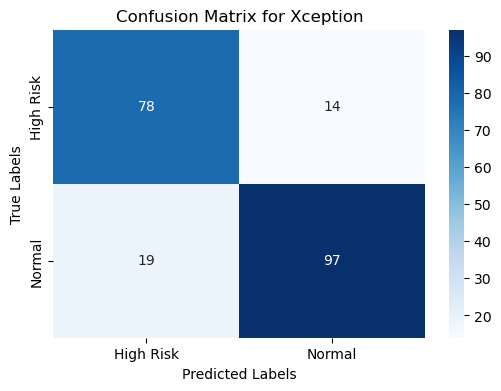

Evaluating EfficientNetB0 Model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Classification Report for EfficientNetB0:

              precision    recall  f1-score   support

   High Risk       0.00      0.00      0.00        92
      Normal       0.56      1.00      0.72       116

    accuracy                           0.56       208
   macro avg       0.28      0.50      0.36       208
weighted avg       0.31      0.56      0.40       208



/Users/shravyadsouza/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shravyadsouza/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shravyadsouza/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


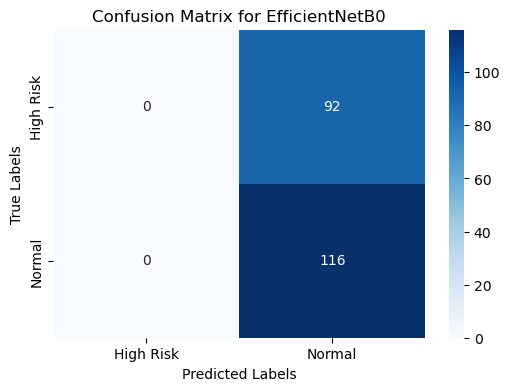

Evaluating DenseNet121 Model...


7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step
Classification Report for DenseNet121:

              precision    recall  f1-score   support

   High Risk       0.86      0.89      0.88        92
      Normal       0.91      0.89      0.90       116

    accuracy                           0.89       208
   macro avg       0.89      0.89      0.89       208
weighted avg       0.89      0.89      0.89       208



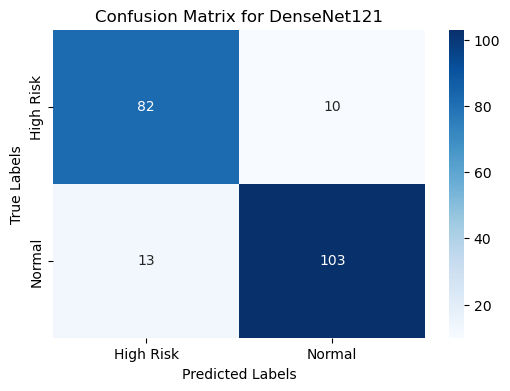

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Function to evaluate the model and generate the confusion matrix
def evaluate_and_plot_confusion_matrix(model, validation_generator, model_name):
    # Get the true labels and predictions
    true_labels = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())
    
    # Predict using the model
    predictions = model.predict(validation_generator)
    predicted_classes = np.where(predictions > 0.5, 1, 0).reshape(-1)  # Threshold at 0.5 for binary classification

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_classes)
    
    # Print classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(true_labels, predicted_classes, target_names=class_labels))

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Evaluate and plot confusion matrix for each model

# CNN Model
#print("Evaluating CNN Model...")
#evaluate_and_plot_confusion_matrix(cnn_history, test_generator, "CNN")

# Xception Model
print("Evaluating Xception Model...")
evaluate_and_plot_confusion_matrix(xception_model, test_generator, "Xception")

# EfficientNetB0 Model
print("Evaluating EfficientNetB0 Model...")
evaluate_and_plot_confusion_matrix(efficientnet_model, test_generator, "EfficientNetB0")

# DenseNet121 Model
print("Evaluating DenseNet121 Model...")
evaluate_and_plot_confusion_matrix(densenet_model, test_generator, "DenseNet121")

In [115]:
import pandas as pd
import os
import cv2
from tqdm import tqdm

# Step 1: Load the Object Detection CSV File
def load_object_detection_csv(csv_file):
    """
    Load object detection CSV file.
    
    Args:
    - csv_file (str): Path to the CSV file.
    
    Returns:
    - DataFrame: Loaded DataFrame with bounding box and image info.
    """
    if os.path.exists(csv_file):
        print(f"Loading CSV file: {csv_file}")
        return pd.read_excel(csv_file)
    else:
        raise FileNotFoundError(f"File not found: {csv_file}")

# Step 2: Extract NT Regions and Create a New CSV File
def extract_nt_regions_and_save(image_dir, output_dir, csv_file, output_csv, threshold=35):
    """
    Extract NT regions from images and save the cropped images and CSV file with NT classifications.

    Args:
    - image_dir (str): Directory containing original images.
    - output_dir (str): Directory to save the cropped ROI images.
    - csv_file (str): Path to object detection CSV file.
    - output_csv (str): Path to save the new CSV file with NT classifications.
    - threshold (int): NT thickness threshold for classifying High Risk vs Normal.

    Returns:
    - None
    """
    os.makedirs(output_dir, exist_ok=True)

    # Load the object detection CSV file
    df = load_object_detection_csv(csv_file)

    # Filter for NT regions
    nt_df = df[df['structure'] == 'NT']  # Modify if column names are different

    # Initialize a list to store results
    results = []

    for _, row in tqdm(nt_df.iterrows(), total=nt_df.shape[0], desc="Extracting ROIs"):
        image_name = row['fname']
        h_min, w_min, h_max, w_max = row['h_min'], row['w_min'], row['h_max'], row['w_max']

        # Construct full image path
        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)

        if image is not None:
            # Extract the NT region using the bounding box coordinates
            roi = image[h_min:h_max, w_min:w_max]
            
            # Save the cropped NT region
            output_filename = f"{os.path.splitext(image_name)[0]}_NT.png"
            output_path = os.path.join(output_dir, output_filename)
            cv2.imwrite(output_path, roi)

            # Calculate NT thickness
            nt_thickness = h_max - h_min

            # Classify as High Risk or Normal based on threshold
            classification = 'High Risk' if nt_thickness > threshold else 'Normal'

            # Append to results list
            results.append({'fname': output_filename, 'nt_thickness': nt_thickness, 'classification': classification})
        else:
            print(f"Error: Image {image_name} not found.")

    # Save the new CSV with extracted ROI info and classifications
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"NT region extraction and classification completed. CSV saved at: {output_csv}")

# Directory containing original images
image_dir = '/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard'  # Update this path

# Directory to save extracted NT images
output_dir = '/Users/shravyadsouza/Downloads/untitled folder/nt_rois_internal'  # Directory to save extracted ROIs

# Object Detection CSV file
object_detection_csv = '/Users/shravyadsouza/Downloads/ObjectDetection.xlsx'  # Use the correct path for the CSV file

# New CSV file to save the NT thickness and classification
output_csv = '/Users/shravyadsouza/Downloads/untitled folder/nt_thickness_classification_internal.csv'

# Step 3: Extract NT regions, calculate thickness, classify, and save to CSV
extract_nt_regions_and_save(image_dir, output_dir, object_detection_csv, output_csv, threshold=35)

Loading CSV file: /Users/shravyadsouza/Downloads/ObjectDetection.xlsx


Extracting ROIs:   0%|                                 | 0/1110 [00:00<?, ?it/s][ WARN:0@38608.714] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/168.png'): can't open/read file: check file path/integrity
[ WARN:0@38608.715] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/169.png'): can't open/read file: check file path/integrity
[ WARN:0@38608.716] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/170.png'): can't open/read file: check file path/integrity
[ WARN:0@38608.716] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus 

Error: Image 168.png not found.
Error: Image 169.png not found.
Error: Image 170.png not found.
Error: Image 171.png not found.
Error: Image 172.png not found.
Error: Image 173.png not found.
Error: Image 9.png not found.
Error: Image 832.png not found.
Error: Image 833.png not found.
Error: Image 834.png not found.
Error: Image 117.png not found.
Error: Image 174.png not found.
Error: Image 175.png not found.
Error: Image 176.png not found.
Error: Image 177.png not found.
Error: Image 178.png not found.
Error: Image 179.png not found.
Error: Image 10.png not found.
Error: Image 835.png not found.
Error: Image 836.png not found.
Error: Image 118.png not found.
Error: Image 180.png not found.
Error: Image 181.png not found.
Error: Image 182.png not found.
Error: Image 183.png not found.
Error: Image 184.png not found.
Error: Image 185.png not found.
Error: Image 11.png not found.
Error: Image 837.png not found.
Error: Image 838.png not found.
Error: Image 119.png not found.
Error: Image

[ WARN:0@38608.797] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/214.png'): can't open/read file: check file path/integrity
[ WARN:0@38608.797] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/215.png'): can't open/read file: check file path/integrity
[ WARN:0@38608.798] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/16.png'): can't open/read file: check file path/integrity
[ WARN:0@38608.798] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/847.png'): can't open/read file: check file 

Error: Image 266.png not found.
Error: Image 267.png not found.
Error: Image 268.png not found.
Error: Image 269.png not found.
Error: Image 270.png not found.
Error: Image 25.png not found.
Error: Image 868.png not found.
Error: Image 869.png not found.
Error: Image 815.png not found.
Error: Image 271.png not found.
Error: Image 272.png not found.
Error: Image 273.png not found.
Error: Image 274.png not found.
Error: Image 275.png not found.
Error: Image 276.png not found.
Error: Image 26.png not found.
Error: Image 870.png not found.
Error: Image 871.png not found.
Error: Image 816.png not found.
Error: Image 277.png not found.
Error: Image 278.png not found.
Error: Image 279.png not found.
Error: Image 280.png not found.
Error: Image 27.png not found.
Error: Image 872.png not found.
Error: Image 817.png not found.
Error: Image 113.png not found.
Error: Image 281.png not found.
Error: Image 282.png not found.
Error: Image 283.png not found.
Error: Image 284.png not found.
Error: Imag

Extracting ROIs:  46%|█████████▋           | 511/1110 [00:00<00:00, 1074.75it/s]an't open/read file: check file path/integrity
[ WARN:0@38609.005] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/32.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.005] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/880.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.006] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/881.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.017] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/

Error: Image 910.png not found.
Error: Image 911.png not found.
Error: Image 822.png not found.
Error: Image 115.png not found.
Error: Image 391.png not found.
Error: Image 392.png not found.
Error: Image 393.png not found.
Error: Image 394.png not found.
Error: Image 395.png not found.
Error: Image 48.png not found.
Error: Image 912.png not found.
Error: Image 913.png not found.
Error: Image 139.png not found.
Error: Image 396.png not found.
Error: Image 397.png not found.
Error: Image 398.png not found.
Error: Image 399.png not found.
Error: Image 400.png not found.
Error: Image 401.png not found.
Error: Image 49.png not found.
Error: Image 914.png not found.
Error: Image 140.png not found.
Error: Image 403.png not found.
Error: Image 404.png not found.
Error: Image 405.png not found.
Error: Image 406.png not found.
Error: Image 407.png not found.
Error: Image 50.png not found.
Error: Image 916.png not found.
Error: Image 917.png not found.
Error: Image 918.png not found.
Error: Imag

rs/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/328.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.034] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/329.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.034] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/330.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.034] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/331.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.034] global loadsave.cpp:241 findDecod

Error: Image 486.png not found.
Error: Image 487.png not found.
Error: Image 489.png not found.
Error: Image 61.png not found.
Error: Image 944.png not found.
Error: Image 945.png not found.
Error: Image 5.png not found.
Error: Image 490.png not found.
Error: Image 491.png not found.
Error: Image 492.png not found.
Error: Image 493.png not found.
Error: Image 494.png not found.
Error: Image 62.png not found.
Error: Image 946.png not found.
Error: Image 947.png not found.
Error: Image 495.png not found.
Error: Image 496.png not found.
Error: Image 497.png not found.
Error: Image 498.png not found.
Error: Image 499.png not found.
Error: Image 500.png not found.
Error: Image 63.png not found.
Error: Image 948.png not found.
Error: Image 949.png not found.


heck file path/integrity
[ WARN:0@38609.054] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/38.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.054] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/892.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.054] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/893.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.054] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/134.png'): can't op

Error: Image 950.png not found.
Error: Image 501.png not found.
Error: Image 502.png not found.
Error: Image 503.png not found.
Error: Image 504.png not found.
Error: Image 505.png not found.
Error: Image 506.png not found.
Error: Image 64.png not found.
Error: Image 951.png not found.
Error: Image 952.png not found.
Error: Image 953.png not found.
Error: Image 0.png not found.
Error: Image 507.png not found.
Error: Image 508.png not found.
Error: Image 509.png not found.
Error: Image 510.png not found.
Error: Image 511.png not found.
Error: Image 512.png not found.
Error: Image 65.png not found.
Error: Image 954.png not found.
Error: Image 955.png not found.
Error: Image 956.png not found.
Error: Image 151.png not found.
Error: Image 514.png not found.
Error: Image 515.png not found.
Error: Image 516.png not found.
Error: Image 517.png not found.
Error: Image 518.png not found.
Error: Image 66.png not found.
Error: Image 957.png not found.
Error: Image 958.png not found.
Error: Image 

obal loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/453.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.197] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/454.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.197] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/455.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.198] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/57.png'): can't open/read file: check file path/integrity
[ WARN:

Error: Image 571.png not found.
Error: Image 572.png not found.
Error: Image 573.png not found.
Error: Image 574.png not found.
Error: Image 575.png not found.
Error: Image 75.png not found.
Error: Image 976.png not found.
Error: Image 977.png not found.
Error: Image 158.png not found.
Error: Image 578.png not found.
Error: Image 579.png not found.
Error: Image 580.png not found.
Error: Image 581.png not found.
Error: Image 76.png not found.
Error: Image 978.png not found.
Error: Image 979.png not found.
Error: Image 980.png not found.
Error: Image 159.png not found.
Error: Image 582.png not found.
Error: Image 583.png not found.
Error: Image 584.png not found.
Error: Image 585.png not found.
Error: Image 586.png not found.
Error: Image 77.png not found.
Error: Image 981.png not found.
Error: Image 160.png not found.
Error: Image 587.png not found.
Error: Image 588.png not found.
Error: Image 589.png not found.
Error: Image 590.png not found.
Error: Image 591.png not found.
Error: Imag

tandard/952.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.852] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/953.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.864] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/0.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.864] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/507.png'): can't open/read file: check file path/integrity
[ WARN:0@38609.865] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Inter

Error: Image 1025.png not found.
Error: Image 1026.png not found.
Error: Image 714.png not found.
Error: Image 715.png not found.
Error: Image 716.png not found.
Error: Image 717.png not found.
Error: Image 718.png not found.
Error: Image 719.png not found.
Error: Image 100.png not found.
Error: Image 1027.png not found.
Error: Image 1028.png not found.
Error: Image 1029.png not found.
Error: Image 605.png not found.
Error: Image 720.png not found.
Error: Image 721.png not found.
Error: Image 722.png not found.
Error: Image 723.png not found.
Error: Image 724.png not found.
Error: Image 1030.png not found.
Error: Image 1031.png not found.
Error: Image 1032.png not found.
Error: Image 616.png not found.
Error: Image 725.png not found.
Error: Image 726.png not found.
Error: Image 727.png not found.
Error: Image 728.png not found.
Error: Image 729.png not found.
Error: Image 730.png not found.
Error: Image 101.png not found.
Error: Image 1033.png not found.
Error: Image 1034.png not found

er imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/566.png'): can't open/read file: check file path/integrity
[ WARN:0@38610.033] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/567.png'): can't open/read file: check file path/integrity
[ WARN:0@38610.034] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/568.png'): can't open/read file: check file path/integrity
[ WARN:0@38610.034] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/74.png'): can't open/read file: check file path/integrity
[ WARN:0@38610.034] global loadsave.cp

Error: Image 990.png not found.
Error: Image 773.png not found.
Error: Image 774.png not found.
Error: Image 775.png not found.
Error: Image 776.png not found.
Error: Image 777.png not found.
Error: Image 778.png not found.
Error: Image 1049.png not found.
Error: Image 1050.png not found.
Error: Image 991.png not found.
Error: Image 606.png not found.
Error: Image 779.png not found.
Error: Image 780.png not found.
Error: Image 781.png not found.
Error: Image 782.png not found.
Error: Image 783.png not found.
Error: Image 108.png not found.
Error: Image 1051.png not found.
Error: Image 1052.png not found.
Error: Image 622.png not found.
Error: Image 784.png not found.
Error: Image 785.png not found.
Error: Image 786.png not found.
Error: Image 787.png not found.
Error: Image 788.png not found.
Error: Image 109.png not found.
Error: Image 1053.png not found.
Error: Image 1054.png not found.
Error: Image 789.png not found.
Error: Image 790.png not found.
Error: Image 792.png not found.
Er

10.128] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/662.png'): can't open/read file: check file path/integrity
[ WARN:0@38610.128] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/663.png'): can't open/read file: check file path/integrity
[ WARN:0@38610.128] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/664.png'): can't open/read file: check file path/integrity
[ WARN:0@38610.128] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/665.png'): can't open/read file: check file path/integr

Error: Image 994.png not found.
Error: Image 995.png not found.
Error: Image 608.png not found.
Error: Image 633.png not found.
Error: Image 634.png not found.
Error: Image 635.png not found.
Error: Image 636.png not found.
Error: Image 637.png not found.
Error: Image 638.png not found.
Error: Image 86.png not found.
Error: Image 996.png not found.
Error: Image 997.png not found.
Error: Image 609.png not found.
Error: Image 639.png not found.
Error: Image 640.png not found.
Error: Image 641.png not found.
Error: Image 642.png not found.
Error: Image 643.png not found.
Error: Image 644.png not found.
Error: Image 87.png not found.
Error: Image 998.png not found.
Error: Image 999.png not found.
Error: Image 81.png not found.
Error: Image 645.png not found.
Error: Image 646.png not found.
Error: Image 647.png not found.
Error: Image 648.png not found.
Error: Image 649.png not found.
Error: Image 650.png not found.
Error: Image 88.png not found.
Error: Image 1000.png not found.
Error: Imag


): can't open/read file: check file path/integrity
[ WARN:0@38610.728] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/85.png'): can't open/read file: check file path/integrity
[ WARN:0@38610.743] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/994.png'): can't open/read file: check file path/integrity
[ WARN:0@38610.787] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/Standard/995.png'): can't open/read file: check file path/integrity
[ WARN:0@38610.788] global loadsave.cpp:241 findDecoder imread_('/Users/shravyadsouza/Downloads/untitled folder/Dataset for Fetus Framework/Dataset for Fetus Framework/Internal Test Set/S

In [109]:
# Print the column names to identify any discrepancies
df = pd.read_csv(object_detection_csv)
print("Columns in CSV file:", df.columns.tolist())

Columns in CSV file: ['fname', 'nt_thickness', 'classification']


Found 72 validated image filenames belonging to 2 classes.
Loading model: CNN from /Users/shravyadsouza/Downloads/untitled folder/final_model_epoch_53.h5


Loading model: Xception from /Users/shravyadsouza/Downloads/untitled folder/xception_model.keras


/Users/shravyadsouza/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loading model: EfficientNetB0 from /Users/shravyadsouza/Downloads/untitled folder/efficientnet_model.keras
Loading model: DenseNet121 from /Users/shravyadsouza/Downloads/untitled folder/densenet_model.keras

Evaluating CNN Model...


/Users/shravyadsouza/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 807ms/step

Classification Report for CNN:

              precision    recall  f1-score   support

   High Risk       0.65      0.92      0.76        37
      Normal       0.85      0.49      0.62        35

    accuracy                           0.71        72
   macro avg       0.75      0.70      0.69        72
weighted avg       0.75      0.71      0.69        72



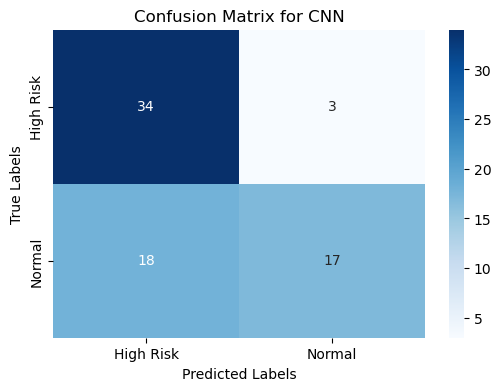

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 779ms/step - accuracy: 0.7057 - loss: 0.9179
Validation Loss for CNN: 0.9166058301925659
Validation Accuracy for CNN: 0.7083333134651184

Evaluating Xception Model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step

Classification Report for Xception:

              precision    recall  f1-score   support

   High Risk       0.79      0.84      0.82        37
      Normal       0.82      0.77      0.79        35

    accuracy                           0.81        72
   macro avg       0.81      0.80      0.80        72
weighted avg       0.81      0.81      0.81        72



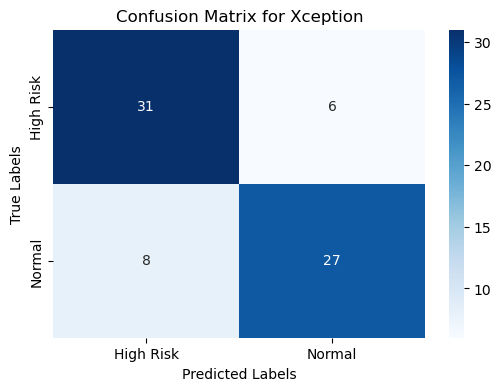

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8247 - loss: 0.3891
Validation Loss for Xception: 0.4041067361831665
Validation Accuracy for Xception: 0.8055555820465088

Evaluating EfficientNetB0 Model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

Classification Report for EfficientNetB0:

              precision    recall  f1-score   support

   High Risk       0.00      0.00      0.00        37
      Normal       0.49      1.00      0.65        35

    accuracy                           0.49        72
   macro avg       0.24      0.50      0.33        72
weighted avg       0.24      0.49      0.32        72



/Users/shravyadsouza/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shravyadsouza/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shravyadsouza/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

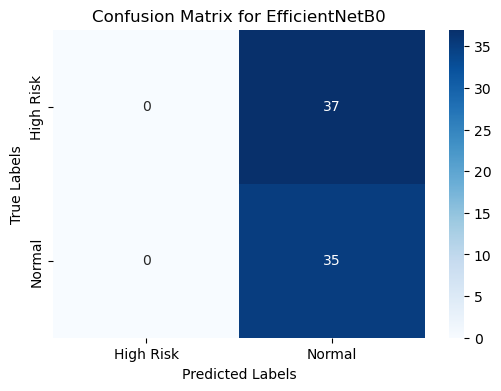

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4891 - loss: 0.7087
Validation Loss for EfficientNetB0: 0.7097036838531494
Validation Accuracy for EfficientNetB0: 0.4861111044883728

Evaluating DenseNet121 Model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step

Classification Report for DenseNet121:

              precision    recall  f1-score   support

   High Risk       0.64      0.95      0.76        37
      Normal       0.88      0.43      0.58        35

    accuracy                           0.69        72
   macro avg       0.76      0.69      0.67        72
weighted avg       0.76      0.69      0.67        72



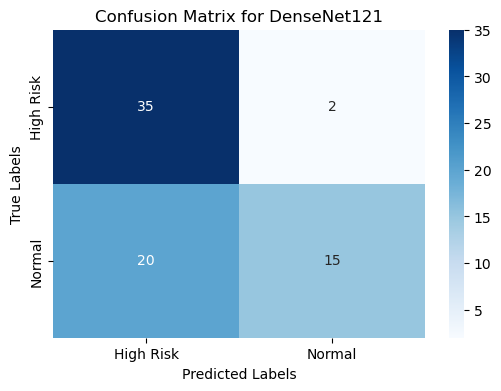

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7105 - loss: 0.5666
Validation Loss for DenseNet121: 0.6017678380012512
Validation Accuracy for DenseNet121: 0.6944444179534912


In [9]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the CSV File with Test Data
test_csv_path = '/Users/shravyadsouza/Downloads/untitled folder/nt_thickness_classification_internal.csv'  # Update this path if needed
test_image_dir = '/Users/shravyadsouza/Downloads/untitled folder/nt_rois_internal'  # Directory where ROIs are saved
df = pd.read_csv(test_csv_path)

# Step 2: Create Image Data Generator for Testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generator for testing
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=test_image_dir,  # Directory where extracted ROIs are stored
    x_col='fname',
    y_col='classification',
    target_size=(100, 400),  # Adjust target size based on model input shape
    batch_size=32,
    class_mode='binary',
    shuffle=False  # No shuffling to maintain order for evaluation
)

# Step 3: Load Pre-trained Models (.keras files)
model_paths = {
    "CNN": "/Users/shravyadsouza/Downloads/untitled folder/final_model_epoch_53.h5",
    "Xception": "/Users/shravyadsouza/Downloads/untitled folder/xception_model.keras",
    "EfficientNetB0": "/Users/shravyadsouza/Downloads/untitled folder/efficientnet_model.keras",
    "DenseNet121": "/Users/shravyadsouza/Downloads/untitled folder/densenet_model.keras"
}

# Load the models using the provided paths
models = {}
for model_name, model_path in model_paths.items():
    if os.path.exists(model_path):
        print(f"Loading model: {model_name} from {model_path}")
        models[model_name] = load_model(model_path)  # Load .keras model file
    else:
        print(f"Model {model_name} not found at {model_path}. Please check the path.")

# Step 4: Evaluate Each Model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} Model...")
    
    # Step 5: Predict and Evaluate
    predictions = model.predict(test_generator)
    predicted_classes = np.where(predictions > 0.5, 1, 0).reshape(-1)  # Convert probabilities to binary classes
    
    # Step 6: True Labels and Class Names
    true_labels = test_generator.classes  # True labels
    class_labels = list(test_generator.class_indices.keys())  # Class labels: ['High Risk', 'Normal']
    
    # Step 7: Classification Report
    report = classification_report(true_labels, predicted_classes, target_names=class_labels, output_dict=True)
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(true_labels, predicted_classes, target_names=class_labels))

    # Step 8: Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Calculate and print model's validation loss and accuracy
    val_loss, val_accuracy = model.evaluate(test_generator)
    print(f"Validation Loss for {model_name}: {val_loss}")
    print(f"Validation Accuracy for {model_name}: {val_accuracy}")
